# Flight Analysis Tool

This notebook analyzes a specific flight by:
1. Displaying TVTW (Traffic Volume Time Window) information for the flight
2. Plotting the flight trajectory and impacted traffic volumes

**Usage:** Enter a flight_identifier to analyze the flight's traffic volume impacts.

In [1]:
import json
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, LineString
import sys
import os

# Add the project source to path for imports
sys.path.append('../src')
from project_tailwind.impact_eval.tvtw_indexer import TVTWIndexer

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

## User Input

Enter the flight_identifier you want to analyze:

In [18]:
# USER INPUT: Enter the flight_identifier to analyze
flight_identifier = "263859637"  # Example flight ID - change this to analyze different flights

print(f"Analyzing flight: {flight_identifier}")

Analyzing flight: 263859637


In [19]:
## Load Required Data

In [20]:
# Load impact vectors (new format with timing information)
with open('../output/so6_occupancy_matrix_with_times.json', 'r') as f:
    flight_data = json.load(f)

# Load traffic volumes
traffic_volumes = gpd.read_file('D:/project-cirrus/cases/traffic_volumes_simplified.geojson')

# Load TVTW indexer
tvtw_indexer = TVTWIndexer.load('../output/tvtw_indexer.json')

# Load CSV trajectory data for the specific flight
trajectory_df = pd.read_csv('D:/project-cirrus/cases/flights_20230801.csv')

print(f"Loaded {len(flight_data)} flights with occupancy data")
print(f"Loaded {len(traffic_volumes)} traffic volumes")
print(f"TVTW indexer: {len(tvtw_indexer._tv_id_to_idx)} traffic volumes, {tvtw_indexer.time_bin_minutes}min bins")
print(f"Loaded {len(trajectory_df)} trajectory segments")

Skipping field elementary_sectors: unsupported OGR type: 5


Loaded 20565 flights with occupancy data
Loaded 358 traffic volumes
TVTW indexer: 358 traffic volumes, 15min bins
Loaded 1214748 trajectory segments


## Analysis Functions

In [21]:
def analyze_flight_tvtws(flight_id, flight_data, tvtw_indexer):
    """
    Print TVTW information for a given flight identifier (updated for new JSON format)
    """
    flight_id_str = str(flight_id)
    
    if flight_id_str not in flight_data:
        print(f"❌ Flight {flight_id} not found in flight data")
        return None
    
    flight_info = flight_data[flight_id_str]
    occupancy_intervals = flight_info.get('occupancy_intervals', [])
    
    print(f"✅ Flight {flight_id} found with {len(occupancy_intervals)} traffic volume occupancies\n")
    
    # Display flight metadata
    print("Flight Information:")
    print("=" * 60)
    print(f"Origin: {flight_info.get('origin', 'N/A')}")
    print(f"Destination: {flight_info.get('destination', 'N/A')}")
    print(f"Takeoff Time: {flight_info.get('takeoff_time', 'N/A')}")
    print(f"Distance: {flight_info.get('distance', 'N/A'):.2f} km")
    print()
    
    print("TVTW Occupancy Information:")
    print("=" * 60)
    
    tvtw_info = []
    for interval in occupancy_intervals:
        tvtw_index = interval['tvtw_index']
        entry_time = interval['entry_time_s']
        exit_time = interval['exit_time_s']
        duration = exit_time - entry_time
        
        tvtw_data = tvtw_indexer.get_human_readable_tvtw(tvtw_index)
        if tvtw_data:
            tv_id, time_window = tvtw_data
            tvtw_info.append({
                'traffic_volume_id': tv_id,
                'time_window': time_window,
                'tvtw_index': tvtw_index,
                'entry_time_s': entry_time,
                'exit_time_s': exit_time,
                'duration_s': duration
            })
    
    # Sort by entry time for chronological order
    tvtw_info.sort(key=lambda x: x['entry_time_s'])
    
    # Print sorted TVTW information with timing details
    for tvtw_data in tvtw_info:
        entry_min = int(tvtw_data['entry_time_s'] // 60)
        entry_sec = int(tvtw_data['entry_time_s'] % 60)
        exit_min = int(tvtw_data['exit_time_s'] // 60)
        exit_sec = int(tvtw_data['exit_time_s'] % 60)
        duration_min = int(tvtw_data['duration_s'] // 60)
        duration_sec = int(tvtw_data['duration_s'] % 60)
        
        print(f"Traffic Volume: {tvtw_data['traffic_volume_id']:12} | Time Window: {tvtw_data['time_window']}")
        print(f"  Entry: {entry_min:02d}:{entry_sec:02d} | Exit: {exit_min:02d}:{exit_sec:02d} | Duration: {duration_min:02d}:{duration_sec:02d}")
        print()
    
    unique_tvs = len(set([t['traffic_volume_id'] for t in tvtw_info]))
    total_duration = sum([t['duration_s'] for t in tvtw_info])
    
    print(f"📊 Total impacted traffic volumes: {unique_tvs}")
    print(f"📊 Total occupancy intervals: {len(tvtw_info)}")
    print(f"📊 Total occupancy time: {int(total_duration // 60):02d}:{int(total_duration % 60):02d}")
    
    return tvtw_info, flight_info

def get_flight_trajectory(flight_id, trajectory_df):
    """
    Extract flight trajectory from CSV data
    """
    if isinstance(flight_id, str):
        flight_id = int(flight_id)
    flight_segments = trajectory_df[trajectory_df['flight_identifier'] == flight_id].copy()
    
    if flight_segments.empty:
        print(f"❌ No trajectory data found for flight {flight_id}")
        return None
    
    # Sort by sequence
    flight_segments = flight_segments.sort_values('sequence')
    
    # Create trajectory coordinates
    coordinates = []
    first_segment = flight_segments.iloc[0]
    coordinates.append((first_segment['longitude_begin'], first_segment['latitude_begin']))
    
    for _, segment in flight_segments.iterrows():
        coordinates.append((segment['longitude_end'], segment['latitude_end']))
    
    # Create trajectory geometry
    trajectory_geom = LineString(coordinates)
    
    # Get flight metadata
    flight_info = {
        'flight_identifier': flight_id,
        'call_sign': first_segment['call_sign'],
        'origin': first_segment['origin_aerodrome'],
        'destination': first_segment['destination_aerodrome'],
        'geometry': trajectory_geom,
        'num_segments': len(flight_segments)
    }
    
    return flight_info

In [22]:
def plot_flight_analysis(flight_id, tvtw_info, flight_trajectory, traffic_volumes, flight_info=None):
    """
    Plot flight trajectory and impacted traffic volumes (updated for new JSON format)
    """
    if not tvtw_info or not flight_trajectory:
        print("❌ Cannot create plot - missing flight data")
        return
    
    # Get impacted traffic volume IDs
    impacted_tv_ids = set([t['traffic_volume_id'] for t in tvtw_info])
    
    # Filter traffic volumes to only impacted ones
    impacted_tvs = traffic_volumes[traffic_volumes['traffic_volume_id'].isin(impacted_tv_ids)]
    
    # Use flight_info from JSON if available, otherwise use trajectory data
    origin = flight_info.get('origin') if flight_info else flight_trajectory['origin']
    destination = flight_info.get('destination') if flight_info else flight_trajectory['destination']
    
    print(f"\n🗺️  Creating visualization for flight {flight_id}")
    print(f"   ✈️  Trajectory: {flight_trajectory['call_sign']} ({origin} → {destination})")
    print(f"   🏢 Impacted traffic volumes: {len(impacted_tvs)}")
    if flight_info:
        print(f"   📏 Distance: {flight_info.get('distance', 'N/A'):.2f} km")
        print(f"   🕐 Takeoff: {flight_info.get('takeoff_time', 'N/A')}")
    
    # Create the plot
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Calculate bounds from trajectory and traffic volumes
    traj_bounds = flight_trajectory['geometry'].bounds
    if not impacted_tvs.empty:
        tv_bounds = impacted_tvs.total_bounds
        min_lon = min(traj_bounds[0], tv_bounds[0]) - 1
        max_lon = max(traj_bounds[2], tv_bounds[2]) + 1
        min_lat = min(traj_bounds[1], tv_bounds[1]) - 1
        max_lat = max(traj_bounds[3], tv_bounds[3]) + 1
    else:
        min_lon, min_lat, max_lon, max_lat = traj_bounds
        min_lon -= 1; max_lon += 1; min_lat -= 1; max_lat += 1
    
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
    ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Plot impacted traffic volumes with color coding by occupancy duration
    if not impacted_tvs.empty:
        # Create a mapping of TV IDs to total occupancy duration
        tv_durations = {}
        for tvtw in tvtw_info:
            tv_id = tvtw['traffic_volume_id']
            duration = tvtw['duration_s']
            tv_durations[tv_id] = tv_durations.get(tv_id, 0) + duration
        
        # Color code by duration (red = longer occupancy)
        max_duration = max(tv_durations.values()) if tv_durations else 1
        
        for _, tv in impacted_tvs.iterrows():
            tv_id = tv['traffic_volume_id']
            duration = tv_durations.get(tv_id, 0)
            intensity = duration / max_duration
            color = plt.cm.Reds(0.3 + 0.7 * intensity)  # Scale from light to dark red
            
            # Plot individual traffic volume
            ax.add_geometries([tv.geometry], ccrs.PlateCarree(),
                            facecolor=color, edgecolor='darkred',
                            alpha=0.7, linewidth=1.5)
            
            # Add traffic volume labels with duration
            centroid = tv.geometry.centroid
            duration_min = int(duration // 60)
            duration_sec = int(duration % 60)
            ax.text(
                centroid.x, centroid.y,
                f"{tv_id}\\n{duration_min:02d}:{duration_sec:02d}",
                transform=ccrs.PlateCarree(),
                ha='center', va='center',
                fontsize=7, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9)
            )
    
    # Plot flight trajectory
    trajectory_coords = list(flight_trajectory['geometry'].coords)
    lons, lats = zip(*trajectory_coords)
    
    ax.plot(lons, lats, 
            color='blue', linewidth=3, alpha=0.8,
            transform=ccrs.PlateCarree(), 
            label=f"Flight {flight_id} ({flight_trajectory['call_sign']})")
    
    # Mark start and end points
    ax.plot(lons[0], lats[0], 'go', markersize=10, transform=ccrs.PlateCarree(), label='Start')
    ax.plot(lons[-1], lats[-1], 'ro', markersize=10, transform=ccrs.PlateCarree(), label='End')
    
    # Create title with enhanced information
    title_parts = [f'Flight {flight_id} Analysis']
    title_parts.append(f'{flight_trajectory["call_sign"]}: {origin} → {destination}')
    title_parts.append(f'Impacted {len(impacted_tvs)} traffic volumes')
    if flight_info:
        total_duration = sum([t['duration_s'] for t in tvtw_info])
        total_min = int(total_duration // 60)
        total_sec = int(total_duration % 60)
        title_parts.append(f'Total occupancy time: {total_min:02d}:{total_sec:02d}')
    
    plt.title('\\n'.join(title_parts), fontsize=12, fontweight='bold')
    
    # Custom legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', linewidth=3, label=f"Flight {flight_id}"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=8, label='Start'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8, label='End'),
        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.6, label='Traffic Volumes (with duration)')
    ]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()

## Flight Analysis

In [23]:
# Step 1: Analyze TVTW information for the flight (updated for new JSON format)
result = analyze_flight_tvtws(flight_identifier, flight_data, tvtw_indexer)
if result:
    tvtw_info, flight_info = result
else:
    tvtw_info, flight_info = None, None

✅ Flight 263859637 found with 12 traffic volume occupancies

Flight Information:
Origin: LFML
Destination: EBBR
Takeoff Time: 2023-08-01T04:43:00
Distance: 531.29 km

TVTW Occupancy Information:
Traffic Volume: LFMML        | Time Window: 04:30-04:45
  Entry: 00:00 | Exit: 02:37 | Duration: 02:37

Traffic Volume: LFMML        | Time Window: 04:45-04:60
  Entry: 02:37 | Exit: 08:19 | Duration: 05:42

Traffic Volume: LSGL4W       | Time Window: 05:00-05:15
  Entry: 28:05 | Exit: 32:28 | Duration: 04:23

Traffic Volume: LSGL4W       | Time Window: 05:15-05:30
  Entry: 32:28 | Exit: 41:14 | Duration: 08:46

Traffic Volume: LFEXE        | Time Window: 05:30-05:45
  Entry: 50:33 | Exit: 62:44 | Duration: 12:10

Traffic Volume: MASB5LL      | Time Window: 05:30-05:45
  Entry: 59:25 | Exit: 62:44 | Duration: 03:18

Traffic Volume: LFEXE        | Time Window: 05:45-05:60
  Entry: 62:44 | Exit: 63:36 | Duration: 00:52

Traffic Volume: MASB5LL      | Time Window: 05:45-05:60
  Entry: 62:44 | Exit

In [24]:
# Step 2: Get flight trajectory from CSV data
flight_trajectory = get_flight_trajectory(flight_identifier, trajectory_df)

if flight_trajectory:
    print(f"\n✈️  Flight Trajectory Information:")
    print(f"   Call Sign: {flight_trajectory['call_sign']}")
    print(f"   Route: {flight_trajectory['origin']} → {flight_trajectory['destination']}")
    print(f"   Segments: {flight_trajectory['num_segments']}")
else:
    print("❌ No trajectory data found")


✈️  Flight Trajectory Information:
   Call Sign: 4181
   Route: LFML → EBBR
   Segments: 55



🗺️  Creating visualization for flight 263859637
   ✈️  Trajectory: 4181 (LFML → EBBR)
   🏢 Impacted traffic volumes: 7
   📏 Distance: 531.29 km
   🕐 Takeoff: 2023-08-01T04:43:00


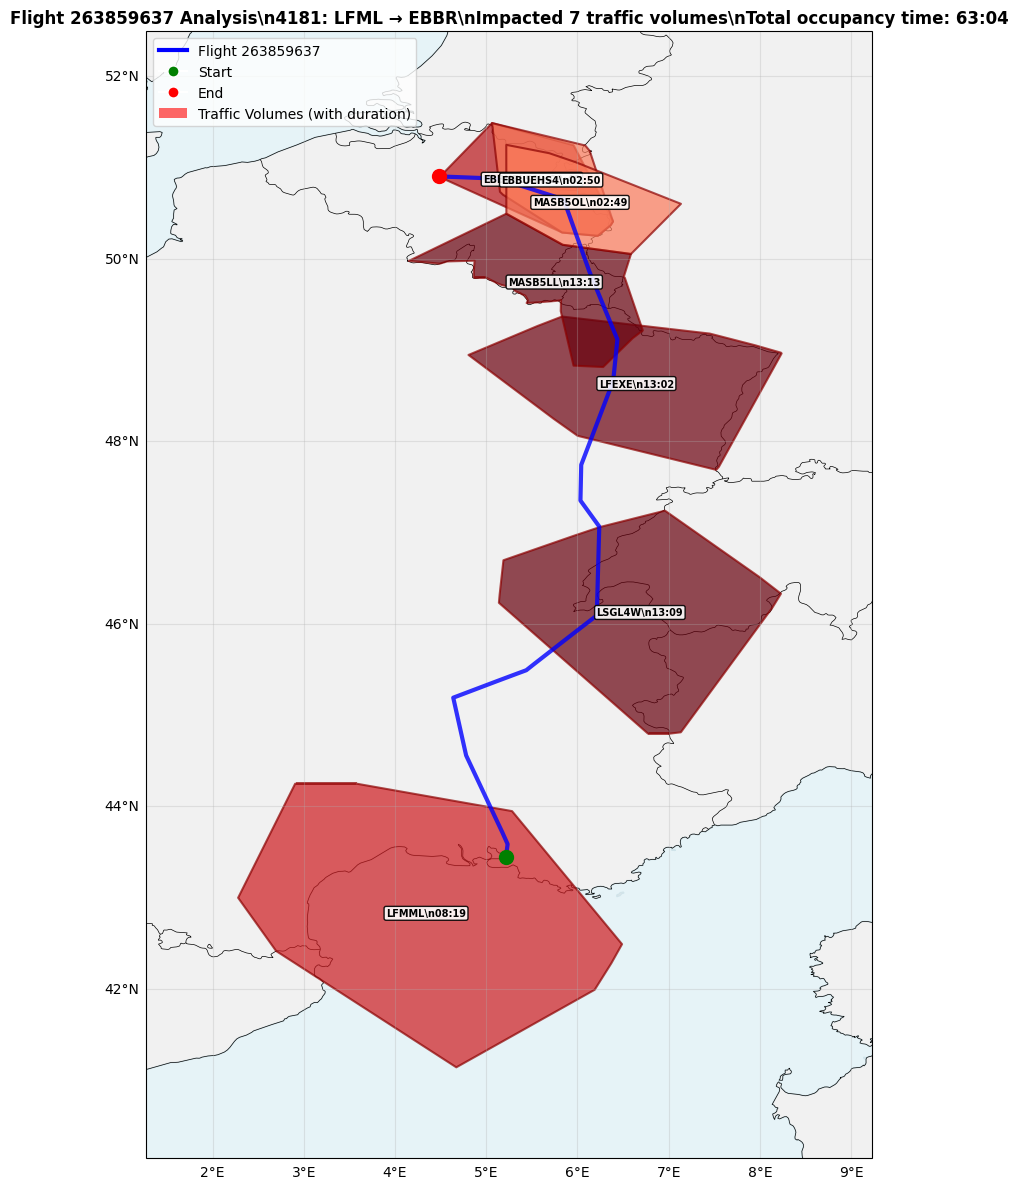

In [25]:
# Step 3: Create visualization (updated for new JSON format)
plot_flight_analysis(flight_identifier, tvtw_info, flight_trajectory, traffic_volumes, flight_info)